<a href="https://colab.research.google.com/github/kavish-p/python-gpu-foreground-segmentation/blob/master/implementation-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning dataset from Github

In [1]:
!git clone https://github.com/lim-eren/CDnet2014.git

Cloning into 'CDnet2014'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


Testing proper cloning of dataset

In [2]:
!ls */train/*

CDnet2014/train/x:
in000685.jpg  in000853.jpg  in001057.jpg  in001217.jpg	in001537.jpg
in000765.jpg  in000873.jpg  in001077.jpg  in001364.jpg	in001613.jpg
in000789.jpg  in000896.jpg  in001104.jpg  in001416.jpg	in001636.jpg
in000809.jpg  in000925.jpg  in001125.jpg  in001477.jpg	in001657.jpg
in000832.jpg  in001009.jpg  in001189.jpg  in001517.jpg	in001680.jpg

CDnet2014/train/y:
gt000685.png  gt000853.png  gt001057.png  gt001217.png	gt001537.png
gt000765.png  gt000873.png  gt001077.png  gt001364.png	gt001613.png
gt000789.png  gt000896.png  gt001104.png  gt001416.png	gt001636.png
gt000809.png  gt000925.png  gt001125.png  gt001477.png	gt001657.png
gt000832.png  gt001009.png  gt001189.png  gt001517.png	gt001680.png


Function to obtain reproducible results across machines

In [0]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Function to obtain input images (X) with corresponding ground-truths (Y)

In [0]:
# load data func
import glob
from keras.preprocessing import image as kImage

def getData(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'x','*.jpg')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'y' ,'*.png')))
    
    X= []
    Y= []
    for i in range(len(X_list)):
        # Load input image
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        X.append(x)
        
        # Load ground-truth label and encode it to label 0 and 1
        x = kImage.load_img(Y_list[i], grayscale = True)
        x = kImage.img_to_array(x)
        x /= 255.0
        x = np.floor(x)
        Y.append(x)
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    return X, Y


Initial a vanilla encoder-decoder model. We adapt the VGG-16 pre-trained model as an encoder, where all fully-connected layers are removed, only the last convolutional layer (block5_conv3) is fine-tuned and rest of the layers are frozen. We use transposed convolutional layers to recover features resolution in the decoder part.
Since it is a binary classification problem, binary_crossentropy is used and the output from the network will be the probability values between 0 and 1. These probability values need to be thresholded in order to obtain binary label 0 or 1, where label 0 represents the background and label 1 represents the foreground.


In [0]:
import keras
from keras.models import Model
from keras.layers import Deconv2D, Input

def initModel():
    ### Encoder
    net_input = Input(shape=(240,320,3))
    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=net_input)
    for layer in vgg16.layers[:17]:
      layer.trainable = False
    
    x = vgg16.layers[-2].output # 2nd layer from the last, block5_conv3
    
    ### Decoder
    x = Deconv2D(256, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(128, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(1, (1,1), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=vgg16.input, outputs=x)
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(lr=5e-4), metrics=['accuracy'])
    return model

We set a learning rate of 5e-4, batch_size of 1, validation_split of 0.2, max-epochs of 100, reduce the learning rate by a factor of 10 when validation loss stops improving in 5 epochs, and stop the training early when validation loss stops improving in 10 epochs. Now, let’s train the model.

In [10]:
# load data
dataset_path = os.path.join('CDnet2014', 'train')
X, Y = getData(dataset_path)

# init the model
model = initModel()

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

model.fit(X, Y, batch_size=1, epochs=5, verbose=2, validation_split=0.2, callbacks=[reduce, early], shuffle=True)
model.save('my_model.h5')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Train on 20 samples, validate on 5 samples
Epoch 1/5
 - 2s - loss: 0.2794 - acc: 0.8900 - val_loss: 0.0735 - val_acc: 0.9727
Epoch 2/5
 - 1s - loss: 0.0794 - acc: 0.9676 - val_loss: 0.0514 - val_acc: 0.9786
Epoch 3/5
 - 1s - loss: 0.0658 - acc: 0.9731 - val_loss: 0.0494 - val_acc: 0.9779
Epoch 4/5
 - 1s - loss: 0.0617 - acc: 0.9730 - val_loss: 0.0448 - val_acc: 0.9801
Epoch 5/5
 - 1s - loss: 0.0444 - acc: 0.9807 - val_loss: 0.0433 - val_acc: 0.9835


Now, let’s test the trained model on test set with Colab GPU

In [11]:
# load test data
dataset_path = os.path.join('CDnet2014', 'test')
X, Y = getData(dataset_path)
# predict
pred = model.predict(X, verbose=1, batch_size=1)
print(tf.Session().run(K.mean(K.equal(Y, K.round(pred)))))


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


10/10 [==============================] - 1s 62ms/step
0.9861771


Plotting of the segmentation mask

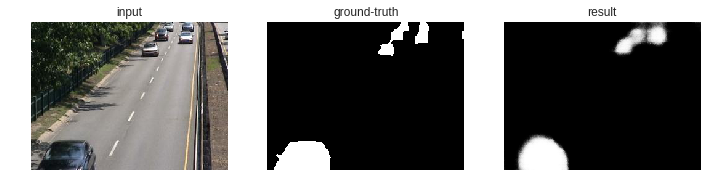

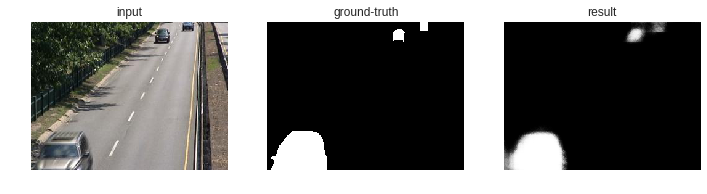

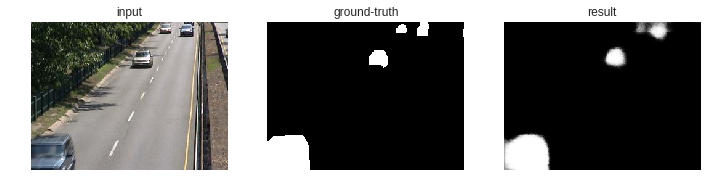

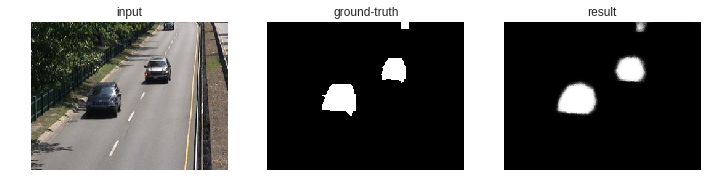

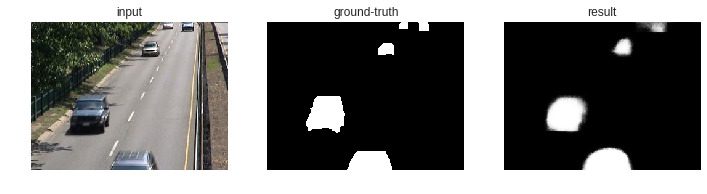

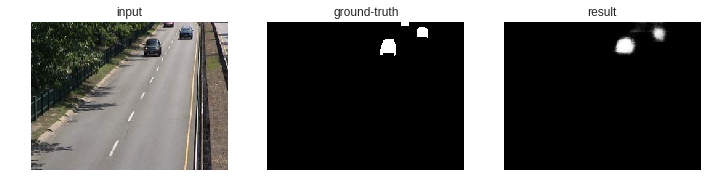

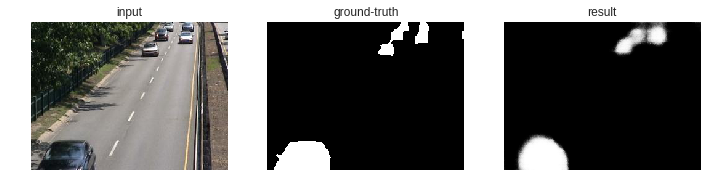

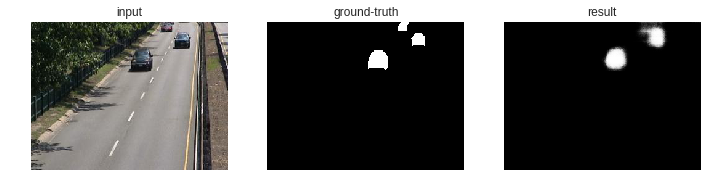

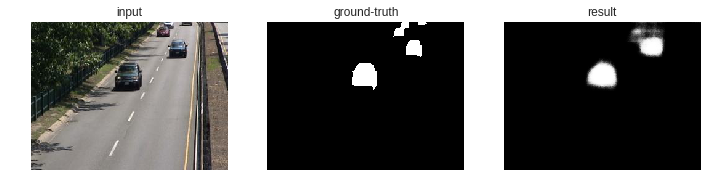

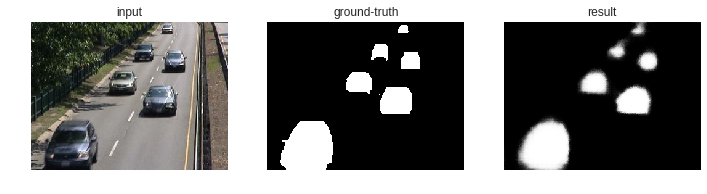

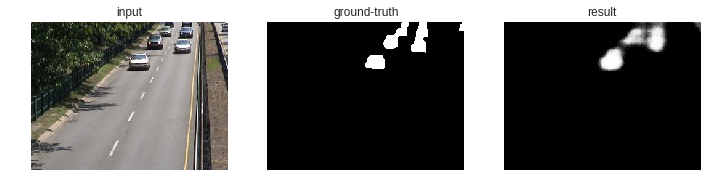

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 9.0)

for i in range(10):
  idx = i # image index that you want to display

  img = np.empty(3, dtype=object)
  img[0] = X[idx]
  img[1] = Y[idx].reshape(Y[idx].shape[0],Y[idx].shape[1])
  img[2] = pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1])
  title = ['input', 'ground-truth', 'result']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    if i==0:
      plt.imshow(img[i].astype('uint8'))
    else:
      plt.imshow(img[i], cmap='gray')
  
    plt.axis('off')
    plt.title(title[i])
  plt.show()
